In [192]:
from collections import OrderedDict
from tabulate import tabulate
import os 

import numpy as np
import pandas as pd

import sklearn as skl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")

## Introduction 
In this notebook, I take the cleaned training and test data, and fit it with a random tree classifier. I use the out-of-bag (OOB) error as an estimate of the expected new data error, and then use a random grid search to optimise the hyperparameters to minimise the OOB error. The variation (from run to run) in the OOB error itself is so large that the hyperparameter optmisation seems a little pointless but there you go...

## Import Data

In [39]:
# Import the training and test data
train = pd.read_csv("data/train_cleaned.csv")
test = pd.read_csv("data/test_cleaned.csv")

## Encode Data

Pandas converts the ticket number category during import. We need to change the datatype back to string so it gets interpreted as categorical data.

In [40]:
train["Common Ticket Number"] = train["Common Ticket Number"].astype('object')
test["Common Ticket Number"] = test["Common Ticket Number"].astype('object')

In [133]:
train["Pclass"] = train["Pclass"].astype('object')
test["Pclass"] = test["Pclass"].astype('object')

Get the categorical columns, check they're all present, and then encode these columns:

In [41]:
cat_columns = (train.dtypes == 'object')
object_cols = list(cat_columns[cat_columns].index)
print(object_cols)

['Sex', 'Embarked', 'Deck', 'Even Room', 'Common Ticket Number', 'Common Title']


In [146]:
y = train["Survived"]
X = train.drop(["Survived",'PassengerId', 'Has Cabin'], axis=1)
cat_cols = make_column_selector(dtype_include=object) (X)
X = pd.get_dummies(X, drop_first=True, columns = cat_cols, dummy_na=True)

In [147]:
X_test = test.drop(['PassengerId', 'Has Cabin'], axis=1)
X_test = pd.get_dummies(X_test, drop_first=True, columns = cat_cols, dummy_na=True)

In [177]:
X_test = test.drop(['PassengerId', 'Has Cabin'], axis=1)
X_test = pd.get_dummies(X_test, drop_first=True, columns = cat_cols, dummy_na=True)
X_test = X_test.reindex(columns= X.columns, fill_value=0)

## Adding in Features

I wanted to compare the accuracy of a Random Forest Classifier (RFC) using solely the data that required no cleaning ("Age", "Sex",...) vs. using both that data and data that required cleaning ("Deck", "Title",... ). 

In [150]:
# input data shrunk down to only features that required no cleaning
X_small = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
cat_cols_small = make_column_selector(dtype_include=object) (X_small)
X_small = pd.get_dummies(X_small, drop_first=True, columns = cat_cols_small)

In [151]:
# set random seed for reproducibility
RANDOM_STATE=0

In [152]:
# create the random forest and fit the data
rfc_small = RandomForestClassifier(oob_score=True, random_state = RANDOM_STATE)
rfc_small.fit(X_small, y)

RandomForestClassifier(oob_score=True, random_state=0)

In [153]:
# create the random forest and fit the data
rfc = RandomForestClassifier(oob_score=True, random_state = RANDOM_STATE)
rfc.fit(X, y)

RandomForestClassifier(oob_score=True, random_state=0)

In [154]:
table = [["Total Features", "OOB Accuracy", "Training Accuracy"], 
         [len(X_small.columns), rfc_small.oob_score_, rfc_small.score(X_small,y)],
         [len(X.columns), rfc.oob_score_, rfc.score(X,y)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤════════════════╤═════════════════════╕
│   Total Features │   OOB Accuracy │   Training Accuracy │
╞══════════════════╪════════════════╪═════════════════════╡
│                9 │       0.822671 │            0.87991  │
├──────────────────┼────────────────┼─────────────────────┤
│               50 │       0.83165  │            0.890011 │
╘══════════════════╧════════════════╧═════════════════════╛


Those extra features do improve OOB accuracy which is encouraging! Though perhaps not by as much as I thought they would...

## Hyperparameters

### Intial Approach to Optimisation

This analsysis is adapted from that given on the [sklearn documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html). We create a list of random forest classifiers, in each one varying the maximum features (```max_features```) that are considered in each split.

In [155]:
labels = ["3", "4", "log2: 5", "sqrt: 6", "7", "8", "None"]
features = [3, 4, "log2", "sqrt",  7, 8, None]
ensembles = [
    (
        label,
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features=x,
            random_state=RANDOM_STATE
        ),
    ) for label, x in zip(labels, features)]

Now we train each one, varying the ensemble size (```n_estimators```). We use ```warm_start=True``` so we can iteratively add estimators without having to re-train previous ensemble members.

In [156]:
# Map a classifier name to a list of (<n_estimators>, <error>) pairs.
errors = OrderedDict((label, []) for label, _ in ensembles)

# Range of ensemble size values (n_estimators) to explore.
min_learners = 20
max_learners = 500

for label, rf in ensembles:
    for i in range(min_learners, max_learners + 1, 20):
        rf.set_params(n_estimators=i)
        rf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - rf.oob_score_
        errors[label].append((i, oob_error))

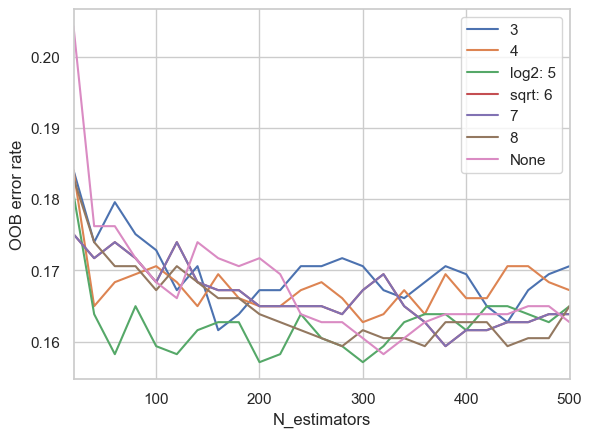

In [157]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, err in errors.items():
    xs, ys = zip(*err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("N_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Errors are quite close, and hard to make out above noise, but does seem that the optimum is somewhere between 5 and 7.

### Better Approach to Optimisation

I wasn't initially aware of how sensitive the optimisation is. If we change another hyperparameter, say "max_depth", then the optimal ```max_features``` can vary quite significantly. A better aproach is to optimise over multiple hyperparameters simultaneously. We will use ```max_depth```, ```min_samples_leaf``` and ```max_features```.

In [158]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, oob_score=True, n_estimators = 300)

params = {
    'max_depth': [2, 5, 9, 10, 11, 12, 13, 14, 15, 16, 25, 30, None],
    'min_samples_leaf': [2, 3, 4, 5],
    'max_features' : [3, 5, 6, 7, 10, 15, 20, 24, 25, 26, 27, 30, None]
}

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=params,
                           cv=[(np.arange(X.shape[0]), np.empty(0, dtype=int))],
                           scoring=lambda forest, X, y: forest.oob_score_,
                           n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
       871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883,
       884, 885, 886, 887, 888, 889, 890]),
                  array([], dtype=int64))],
             estimator=RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                              oob_score=True, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5, 9, 10, 11, 12, 13, 14, 15, 16, 25,
                                       30, None],
                         'max_features': [3, 5, 6, 7, 10, 15, 20, 24, 25, 26,
                                          27, 30, None],
                         'min_samples_leaf': [2, 3, 4, 5]},
             scoring=<function <lambda> at 0x1586a7560>)

In [160]:
grid_search.best_score_

0.8395061728395061

In [161]:
rf_optimim = grid_search.best_estimator_
rf_optimum

RandomForestClassifier(max_depth=12, max_features=27, min_samples_leaf=2,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=0)

We will use these parameters in the final model. There is one other parameter we should be able to change to improve the accuracy without affecting the other hyperparameters...

### Varying Ensemble Size

The OOB error will decrease (on average) with the number of estimators in the ensemble. We just need to check how close we are to the limit value (infinite number of estimators).

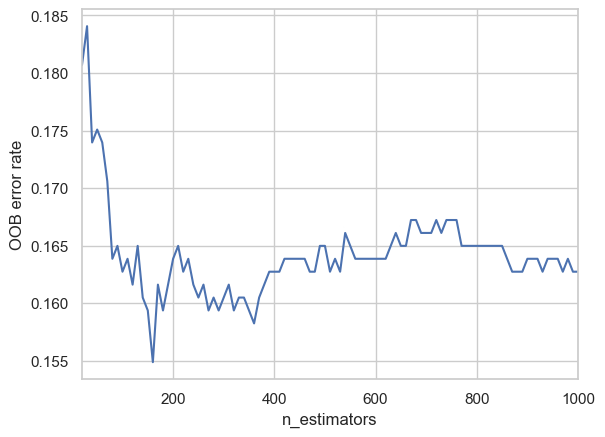

In [199]:
min_estimators = 20
max_estimators = 1000

rf = RandomForestClassifier(oob_score=True, random_state=RANDOM_STATE,
                         warm_start=True, max_features=27, max_depth=12, min_samples_leaf=2)
errors = []
for i in range(min_estimators, max_estimators + 1, 10):
    rf.set_params(n_estimators=i)
    rf.fit(X, y)
    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    errors.append((i, oob_error))

xs, ys = zip(*errors)
plt.plot(xs, ys)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

Seems to approach the limit value quite fast - notice the large drop in error from 20 to 100 estimators. However, the variation in the error is large, so there does not seem much point in going any further than 100 estimators. On the other hand, its hardly computationally expensive with even a 1000 estimators...

## Predict and Export 

Final model:

In [202]:
rfc = RandomForestClassifier(oob_score=True, max_features=27, 
                             max_depth=12, min_samples_leaf=2, n_estimators=1000)
rfc.fit(X, y)

RandomForestClassifier(max_depth=12, max_features=27, min_samples_leaf=2,
                       n_estimators=1000, oob_score=True)

Final validation and training scores:

In [204]:
rfc.oob_score_

0.835016835016835

In [205]:
rfc.score(X,y)

0.8933782267115601

Finally, we will predict and export the predictions:

In [180]:
survival = rfc.predict(X_test)

In [190]:
predictions = pd.DataFrame(data={"PassengerId": test["PassengerId"].values,  "Survived" : survival})

In [193]:
predictions.to_csv(os.getcwd() + "/predictions.csv", index = False)